#Imports

In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.7 MB/s eta 0:00:00


In [2]:
#basic
from pathlib import Path
import random
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
# import PIL
from PIL import Image

#modeling
from sklearn.model_selection import train_test_split
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import timm
from torch.nn import functional as F
import torch.optim as optim
import copy

%matplotlib inline

#Data loading

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

100% 1.62G/1.62G [00:20<00:00, 67.9MB/s]
100% 1.62G/1.62G [00:20<00:00, 86.9MB/s]


In [5]:
!unzip /content/ocular-disease-recognition-odir5k.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg

In [6]:
df_all = pd.read_csv('/content/full_df.csv')

In [7]:
df_all.sample(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
6158,4407,54,Male,4407_left.jpg,4407_right.jpg,severe nonproliferative retinopathy,severe nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4407_left.jpg
447,513,55,Female,513_left.jpg,513_right.jpg,normal fundus,dry age-related macular degeneration,0,0,0,0,1,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",513_right.jpg
1151,1477,71,Female,1477_left.jpg,1477_right.jpg,glaucoma,glaucoma,0,0,1,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['G'],"[0, 0, 1, 0, 0, 0, 0, 0]",1477_right.jpg
5391,3080,76,Male,3080_left.jpg,3080_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3080_left.jpg
1138,1454,79,Male,1454_left.jpg,1454_right.jpg,epiretinal membrane,cataract,0,0,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",1454_right.jpg


In [8]:
df_all[df_all['ID']==2244]

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
1505,2244,76,Male,2244_left.jpg,2244_right.jpg,lens dust，cataract,cataract，lens dust,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",2244_right.jpg


In [9]:
df_all['left_cataract'] = df_all['Left-Diagnostic Keywords'].apply(lambda x: 1 if 'cataract' in str(x).lower() else 0)
df_all['right_cataract'] = df_all['Right-Diagnostic Keywords'].apply(lambda x: 1 if 'cataract' in str(x).lower() else 0)

In [10]:
left_cataract = df_all[df_all['left_cataract'] == 1]['Left-Fundus'].values
right_cataract = df_all[df_all['right_cataract'] == 1]['Right-Fundus'].values
print(f'Number of images in left cataract: {len(left_cataract)}')
print(f'Number of images in right cataract: {len(right_cataract)}')

Number of images in left cataract: 304
Number of images in right cataract: 290


In [11]:
left_normal = df_all[(df_all['C']==0) & (df_all['Left-Diagnostic Keywords']=='normal fundus')]['Left-Fundus'].values
right_normal = df_all[(df_all['C']==0) & (df_all['Right-Diagnostic Keywords']=='normal fundus')]['Right-Fundus'].values
print(f'Number of images in left normal: {len(left_normal)}')
print(f'Number of images in right normal: {len(right_normal)}')

Number of images in left normal: 2748
Number of images in right normal: 2657


In [12]:
cataract = np.concatenate([left_cataract, right_cataract])
normal = np.concatenate([left_normal, right_normal])

In [13]:
cataract = pd.DataFrame(cataract, columns=['filename'])
normal = pd.DataFrame(normal, columns=['filename'])

In [14]:
cataract['label'] = 1
normal['label'] = 0

In [15]:
df_combined = pd.concat([cataract, normal])
df_combined.sample(10)

,filename,label
2728,4523_left.jpg,0
1716,2430_left.jpg,0
4514,2542_right.jpg,0
5082,3184_right.jpg,0
5156,3266_right.jpg,0
3813,3221_right.jpg,0
312,553_right.jpg,1
4159,363_right.jpg,0
2656,4152_left.jpg,0
2053,2820_left.jpg,0


##Data review

In [16]:
root_path = Path('/content/preprocessed_images')

In [17]:
def rand_image():
  idx = random.randint(0, len(df_combined))
  filename = df_combined.filename.iloc[idx]
  image = root_path/filename
  label = df_combined.label.iloc[idx]
  return image, label

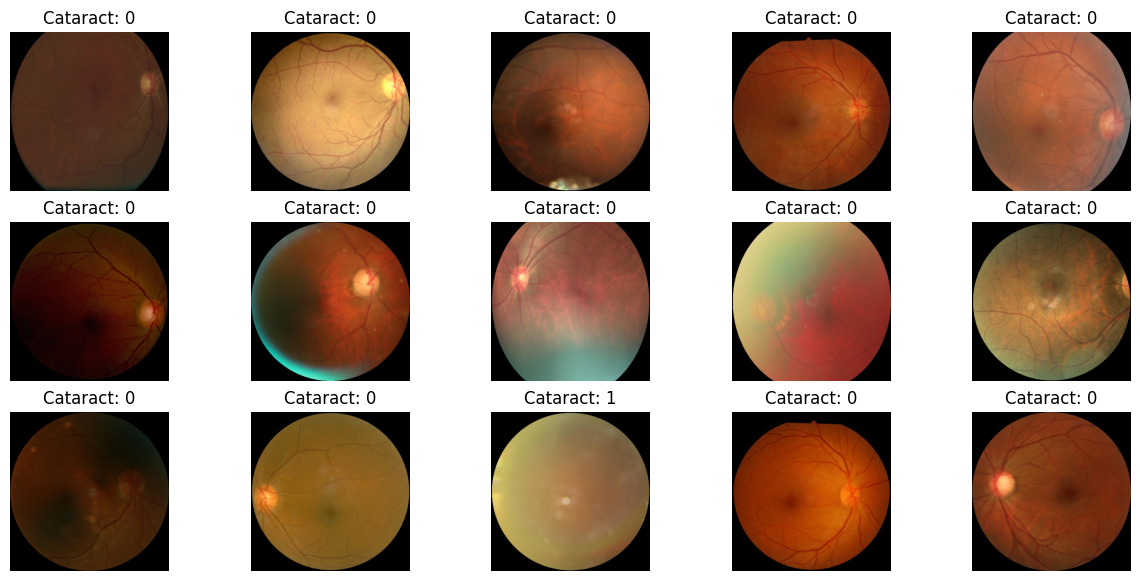

In [18]:
fig, axs = plt.subplots(3, 5, figsize=(15,7))
axs = axs.flatten()

for ax in axs:
  img, label = rand_image()
  img = Image.open(img)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f'Cataract: {label}')

##Sample tranformations

In [19]:
list_transforms = [transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                                 transforms.RandomEqualize(),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomAffine(degrees=(-10,10), translate=(0, 0.1), scale=(0.8, 1.2)),
                                 transforms.RandomInvert()]

In [20]:
# fig, axs = plt.subplots(1,6, figsize=(15,3))
# axs = axs.flatten()
# img, label = rand_image()
# img = Image.open(img)


# for i, ax in enumerate(axs):
#   axs[0].imshow(img)
#   axs[0].set_title('original image')
#   transf = list_transforms[i-1]
#   ax = axs[i]
#   ax.axis('off')
#   transf_img = transf(img)
#   ax.imshow(transf_img)

In [21]:
list_color = [transforms.RandomAutocontrast(),
              transforms.RandomAutocontrast(),
              transforms.RandomAutocontrast(),
              transforms.RandomAutocontrast(),
              transforms.RandomAutocontrast()]

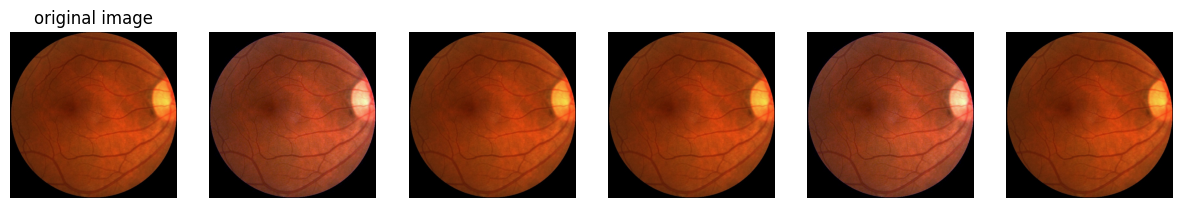

In [22]:
fig, axs = plt.subplots(1,6, figsize=(15,3))
axs = axs.flatten()
img, label = rand_image()
img = Image.open(img)


for i, ax in enumerate(axs):
  axs[0].imshow(img)
  axs[0].set_title('original image')
  transf = list_color[i-1]
  ax = axs[i]
  ax.axis('off')
  transf_img = transf(img)
  ax.imshow(transf_img)

#Split to train, validation and test sets

In [23]:
X = df_combined.copy()
y = df_combined['label']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=6)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=6)

In [25]:
path_dict = {'train/': X_train, 'val/': X_val, 'test/': X_test}

for key, df in path_dict.items():

  save_path = Path(key)

  for i, img in enumerate(tqdm(df.filename)):
    img_path = root_path/img

    label = df.label.iloc[i]

    img_save_path = root_path/save_path/str(label)
    img_save_path.mkdir(parents=True, exist_ok=True)

    if img_path.exists():
      shutil.copy(img_path, img_save_path)

100%|██████████| 1200/1200 [00:00<00:00, 3619.74it/s]


#Create Pytorch Data Generators

In [26]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                                       transforms.RandomEqualize(),
                                       transforms.RandomAffine(degrees=(-10,10), translate=(0, 0.1), scale=(0.8, 1.2)),
                                       transforms.RandomInvert(),
                                       transforms.RandomGrayscale(p=0.2)
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(degrees=(-5, 5)),
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       normalize])

val_transforms = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     normalize])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     normalize])

In [84]:
train_path = '/content/preprocessed_images/train'
val_path = '/content/preprocessed_images/val'
test_path = '/content/preprocessed_images/test'

In [85]:
train_dataset = datasets.ImageFolder(train_path, train_transforms)
val_dataset = datasets.ImageFolder(val_path, val_transforms)
test_dataset = datasets.ImageFolder(test_path,test_transforms)

In [28]:
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])

# def create_dataloaders(*args):
#   data_transforms = {
#       'train':
#       transforms.Compose([
#           transforms.Resize((224,224)),
#           *args,
#           transforms.ToTensor(),
#           normalize
#           ]),
#       'val':
#       transforms.Compose([
#           transforms.Resize((224,224)),
#           transforms.ToTensor(),
#           normalize
#           ]),
#       'test':
#       transforms.Compose([
#           transforms.Resize((224,224)),
#           transforms.ToTensor(),
#           normalize
#           ])
#   }

#   image_datasets = {
#       'train':
#       datasets.ImageFolder(train_path, data_transforms['train']),
#       'val':
#       datasets.ImageFolder(val_path, data_transforms['val']),
#       'test':
#       datasets.ImageFolder(test_path, data_transforms['test'])
#   }

#   dataloaders = {
#       'train':
#       torch.utils.data.DataLoader(image_datasets['train'],
#                                   batch_size=32,
#                                   shuffle=True,
#                                   num_workers=1),
#       'val':
#       torch.utils.data.DataLoader(image_datasets['val'],
#                                   batch_size=32,
#                                   shuffle=False,
#                                   num_workers=1),
#       'test':
#       torch.utils.data.DataLoader(image_datasets['test'],
#                                   batch_size=32,
#                                   shuffle=False,
#                                   num_workers=1)
#   }
#   return dataloaders

In [29]:
batch_size = 32
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

#Model

##Create the model

In [30]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(device)

cuda


In [68]:
# Load the EfficientNet architecture
model_b0_1 = timm.create_model('efficientnet_b0', pretrained=True)

for param in model_b0_1.parameters():
    param.requires_grad = False

# Replace the last classification layer with a new layer with two outputs
num_ftrs = model_b0_1.classifier.in_features
model_b0_1.classifier = nn.Linear(num_ftrs, 2)

# Add a softmax function at the end
model_b0_1 = nn.Sequential(model_b0_1, nn.Softmax(dim=1))

model_b0_1 = model_b0_1.to(device)

In [32]:
# # Load the EfficientNet architecture
# efficientnet_model = timm.create_model('efficientnet_b0', pretrained=True)

# # Replace the last classification layer with a new layer with two outputs
# num_ftrs = efficientnet_model.classifier.in_features
# efficientnet_model.classifier = nn.Sequential(
#     nn.Linear(num_ftrs, 256),  # Dodaj dodatkową warstwę
#     nn.ReLU(),  # Funkcja aktywacji
#     nn.BatchNorm1d(256),  # Batch Normalization
#     nn.Dropout(0.5),  # Dropout dla regularyzacji
#     nn.Linear(256, 2)  # Warstwa klasyfikacyjna z dwoma wyjściami (2 klasy)
# )

# # Dodaj funkcję softmax na końcu
# efficientnet_model = nn.Sequential(
#     efficientnet_model,
#     nn.Softmax(dim=1)
# )

# # Wydrukuj zaktualizowaną architekturę
# print(efficientnet_model)

In [33]:
# model = models.resnet101(pretrained=True).to(device)

# for param in model.parameters():
#     param.requires_grad = False

# model.fc = nn.Sequential(
#                nn.Linear(2048, 128),
#                nn.ReLU(inplace=True),
#                nn.Linear(128, 2)).to(device)

In [69]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_b0_1.parameters(), lr=0.001)

##Train model function

In [94]:
def train_model(dataloaders, model, criterion, optimizer, num_epochs=3):

    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    best_train_accuracy = 0
    best_val_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        metrics = {}

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            corrects = 0
            r_positives = 0
            t_positives = 0
            tf_positives = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                metrics[phase] = {}
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                corrects += sum(preds == labels.data)
                r_positives += sum(labels == 1).item()
                t_positives += sum((preds == labels) & (labels == 1)).item()
                tf_positives += sum(preds == 1).item()

            num_inputs = len(dataloaders[phase].dataset)
            metrics[phase]['loss'] = round(running_loss / num_inputs, 4)
            metrics[phase]['acc'] = round(corrects.item() / num_inputs, 4)
            metrics[phase]['precision'] = round(t_positives / tf_positives, 4)
            metrics[phase]['recall'] = round(t_positives / r_positives, 4)
            metrics[phase]['F1'] = round(calculate_f1(metrics[phase]['precision'], metrics[phase]['recall']), 4)

            print(f'{phase} loss: {metrics[phase]["loss"]:.4f}, {phase} accuracy: {metrics[phase]["acc"]:.4f}')

        if (metrics['val']['acc'] >= best_val_accuracy) and (metrics['train']['acc'] >= best_train_accuracy):
          best_val_accuracy = metrics['val']['acc']
          best_train_accuracy = metrics['train']['acc']
          best_metrics = pd.DataFrame(metrics)
          best_model = model

        train_loss_history.append(metrics['train']['loss'])
        train_accuracy_history.append(metrics['train']['acc'])
        val_loss_history.append(metrics['val']['loss'])
        val_accuracy_history.append(metrics['val']['acc'])

        train_history = [train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history]

    return best_model, best_metrics, train_history

In [87]:
num_epochs = 10
model = model_b0_1
dataloaders = {'train': train_loader, 'val': val_loader}

In [58]:
def calculate_f1(precision, recall):
  F1 = 2 * precision * recall / (precision + recall)
  return F1

In [88]:
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []
best_train_accuracy = 0
best_val_accuracy = 0

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')

    metrics = {}

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        corrects = 0
        r_positives = 0
        t_positives = 0
        tf_positives = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            metrics[phase] = {}
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            corrects += sum(preds == labels.data).item()
            r_positives += sum(labels == 1).item()
            t_positives += sum((preds == labels) & (labels == 1)).item()
            tf_positives += sum(preds == 1).item()

        num_inputs = len(dataloaders[phase].dataset)
        metrics[phase]['loss'] = round(running_loss / num_inputs, 4)
        metrics[phase]['acc'] = round(corrects / num_inputs, 4)
        metrics[phase]['precision'] = round(t_positives / tf_positives, 4)
        metrics[phase]['recall'] = round(t_positives / r_positives, 4)
        metrics[phase]['F1'] = round(calculate_f1(metrics[phase]['precision'], metrics[phase]['recall']), 4)


        print(f'{phase} loss: {metrics[phase]["loss"]:.4f}, {phase} accuracy: {metrics[phase]["acc"]:.4f}')

    if (metrics['val']['acc'] >= best_val_accuracy): # and (metrics['train']['acc'] >= best_train_accuracy):
      best_val_accuracy = metrics['val']['acc']
      best_train_accuracy = metrics['train']['acc']
      best_metrics = pd.DataFrame(metrics)
      best_model = model

    train_loss_history.append(metrics['train']['loss'])
    train_accuracy_history.append(metrics['train']['acc'])
    val_loss_history.append(metrics['val']['loss'])
    val_accuracy_history.append(metrics['val']['acc'])

    train_history = [train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history]

Epoch 1/10
train loss: 0.3440, train accuracy: 0.9695
val loss: 0.3436, val accuracy: 0.9674
Epoch 2/10
train loss: 0.3421, train accuracy: 0.9710
val loss: 0.3420, val accuracy: 0.9693
Epoch 3/10
train loss: 0.3429, train accuracy: 0.9714
val loss: 0.3458, val accuracy: 0.9656
Epoch 4/10
train loss: 0.3440, train accuracy: 0.9687
val loss: 0.3454, val accuracy: 0.9656
Epoch 5/10
train loss: 0.3411, train accuracy: 0.9734
val loss: 0.3448, val accuracy: 0.9674
Epoch 6/10
train loss: 0.3410, train accuracy: 0.9722
val loss: 0.3452, val accuracy: 0.9656
Epoch 7/10
train loss: 0.3432, train accuracy: 0.9710
val loss: 0.3428, val accuracy: 0.9656
Epoch 8/10
train loss: 0.3408, train accuracy: 0.9734
val loss: 0.3431, val accuracy: 0.9684
Epoch 9/10
train loss: 0.3427, train accuracy: 0.9702
val loss: 0.3430, val accuracy: 0.9665
Epoch 10/10
train loss: 0.3450, train accuracy: 0.9679
val loss: 0.3430, val accuracy: 0.9693


In [89]:
best_metrics

,train,val
loss,0.3450,0.3430
acc,0.9679,0.9693
precision,0.8471,0.8125
recall,0.8200,0.8835
F1,0.8333,0.8465


In [74]:
corrects

1041

In [75]:
positives

103

In [76]:
preds

tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       device='cuda:0')

In [77]:
labels

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')

In [81]:
sum((preds == labels) & (labels == 1)).item()

16

In [ ]:
def test_model(dataloader, model, criterion):

  running_loss = 0.0
  running_corrects = 0

  model.eval()

  for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += sum(preds == labels.data)

    num_inputs = len(dataloader.dataset)
    test_loss = running_loss / num_inputs
    test_accuracy = running_corrects.item() / num_inputs

  return test_loss, test_accuracy

In [38]:
def plot_learning(train_history):
  fig, axs = plt.subplots(1, 2, figsize=(15, 5))
  history = {'Accuracy': [train_history[0], train_history[1]], 'Loss': [train_history[2], train_history[3]]}

  for i, name in enumerate(['Accuracy', 'Loss']):
    ax = axs[i]
    ax.plot(history[name][0], label='train')
    ax.plot(history[name][1], label='validation')
    ax.set_title(name)
    ax.legend()
    ax.set_xlabel('no. of epochs')
  plt.show()

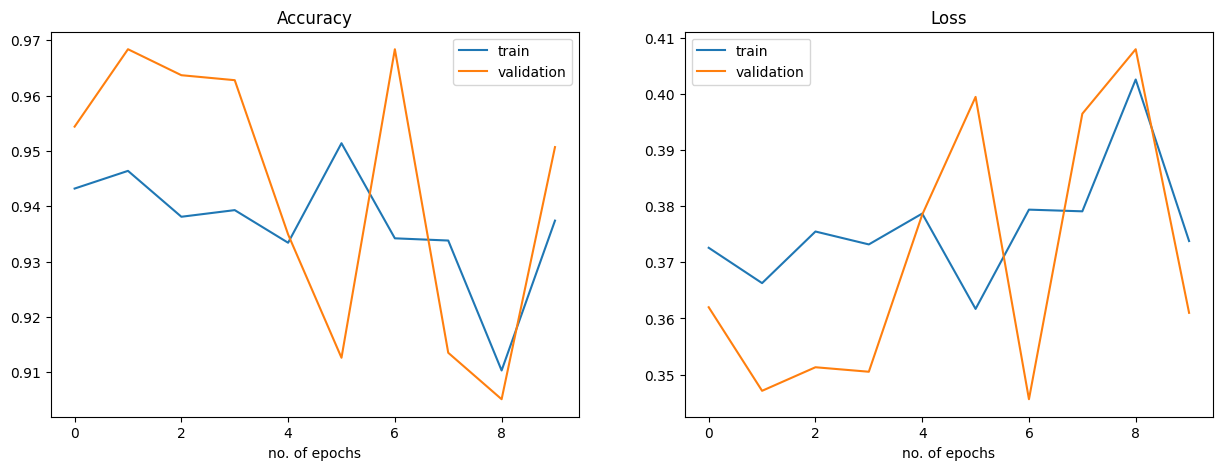

In [39]:
plot_learning(train_history)

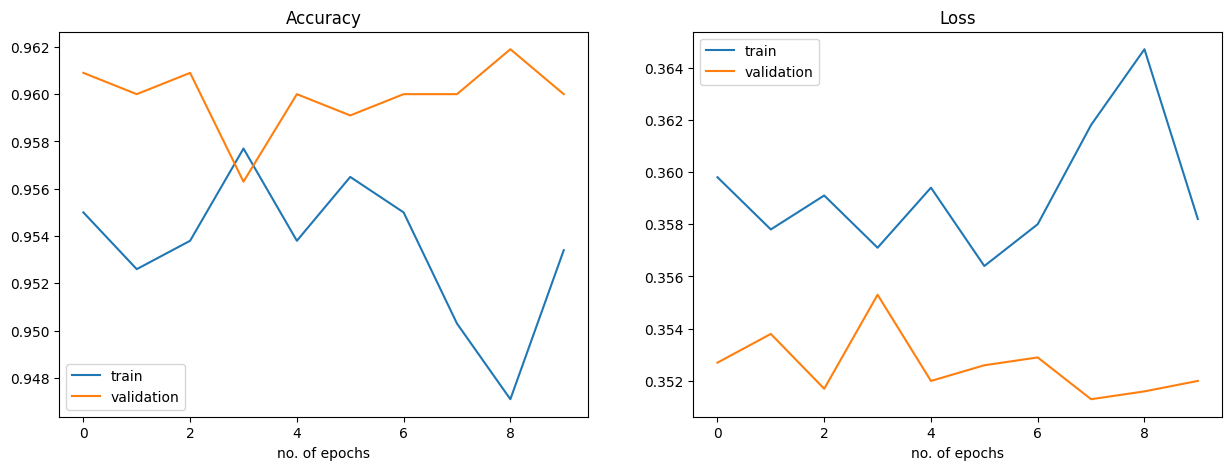

In [44]:
plot_learning(train_history)

##Selecting transformations

In [91]:
transformations = {'ColorJitter': transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                   'RandomEqualize': transforms.RandomEqualize(),
                   'RandomInvert': transforms.RandomInvert(),
                   'RandomAutocontrast': transforms.RandomAutocontrast(),
                   'RandomGrayscale': transforms.RandomGrayscale(p=0.5),
                   'RandomHorizontalFlip': transforms.RandomHorizontalFlip(),
                   'RandomRotation': transforms.RandomRotation(degrees=(-5, 5)),
                   'RandomCrop': transforms.RandomCrop(size=(200, 200))}

In [109]:
def create_trying_loader(transform, val_loader):
  data_tranforms = transforms.Compose([transform,
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       normalize])
  trying_dataset = datasets.ImageFolder(train_path, data_tranforms)
  trying_loader = torch.utils.data.DataLoader(trying_dataset, batch_size = 32,
                                         shuffle=True, num_workers=2)
  dataloaders = {'train': trying_loader, 'val': val_loader}

  return dataloaders

In [ ]:
dataloaders = {'train': train_loader, 'val': val_loader}

In [110]:
def check_transfrom(transformations, val_loader):
  i = 0
  valid_scores = pd.DataFrame({'transformations': transformations.keys(),
                               'accuracy': np.zeros(len(transformations)),
                               'precision': np.zeros(len(transformations)),
                               'recall': np.zeros(len(transformations)),
                               'F1': np.zeros(len(transformations))})

  for key, transform in transformations.items():
    print(key)
    dataloaders = create_trying_loader(transform, val_loader)
    trained_model, metrics, history = train_model(dataloaders, model, criterion, optimizer, num_epochs=10)
    print()

    valid_scores.iloc[i,1] = metrics.iloc[1,1]

    i+=1
  return valid_scores

In [122]:
i = 0
valid_scores = pd.DataFrame({'transformations': transformations.keys(),
                              'accuracy': np.zeros(len(transformations)),
                              'precision': np.zeros(len(transformations)),
                              'recall': np.zeros(len(transformations)),
                              'F1': np.zeros(len(transformations))})

for key, transform in transformations.items():
  print(key)
  dataloaders = create_trying_loader(transform, val_loader)
  trained_model, metrics, history = train_model(dataloaders, model, criterion, optimizer, num_epochs=10)
  print()

  for j in list(range(1,5)):
    valid_scores.iloc[i,j] = metrics.iloc[j,1]

  i+=1

ColorJitter
Epoch 1/10
train loss: 0.3403, train accuracy: 0.9730
val loss: 0.3365, val accuracy: 0.9758
Epoch 2/10
train loss: 0.3374, train accuracy: 0.9769
val loss: 0.3365, val accuracy: 0.9758
Epoch 3/10
train loss: 0.3384, train accuracy: 0.9742
val loss: 0.3358, val accuracy: 0.9749
Epoch 4/10
train loss: 0.3375, train accuracy: 0.9757
val loss: 0.3347, val accuracy: 0.9786
Epoch 5/10
train loss: 0.3379, train accuracy: 0.9749
val loss: 0.3366, val accuracy: 0.9740
Epoch 6/10
train loss: 0.3377, train accuracy: 0.9749
val loss: 0.3347, val accuracy: 0.9777
Epoch 7/10
train loss: 0.3366, train accuracy: 0.9761
val loss: 0.3345, val accuracy: 0.9777
Epoch 8/10
train loss: 0.3357, train accuracy: 0.9792
val loss: 0.3342, val accuracy: 0.9786
Epoch 9/10
train loss: 0.3383, train accuracy: 0.9757
val loss: 0.3335, val accuracy: 0.9777
Epoch 10/10
train loss: 0.3357, train accuracy: 0.9781
val loss: 0.3349, val accuracy: 0.9758

RandomEqualize
Epoch 1/10
train loss: 0.3405, train accu

In [123]:
metrics

,train,val
loss,0.3624,0.3585
acc,0.9503,0.9563
precision,0.7573,0.7545
recall,0.7240,0.8058
F1,0.7403,0.7793


In [114]:
metrics.iloc[2,1]

0.6621

In [121]:
l = list(range(1,5))
l

[1, 2, 3, 4]

In [124]:
valid_scores

,transformations,accuracy,precision,recall,F1
0,ColorJitter,0.9786,0.9082,0.8641,0.8856
1,RandomEqualize,0.9842,0.9574,0.8738,0.9137
2,RandomInvert,0.9842,0.9479,0.8835,0.9146
3,RandomAutocontrast,0.9860,0.9583,0.8932,0.9246
4,RandomGrayscale,0.9823,0.9286,0.8835,0.9055
5,RandomHorizontalFlip,0.9888,0.9505,0.9320,0.9412
6,RandomRotation,0.9879,0.9500,0.9223,0.9359
7,RandomCrop,0.9563,0.7545,0.8058,0.7793


In [ ]:
valid_scores = check_transfrom(transformations)

In [ ]:
valid_scores

,transformations,Validation accuracy
0,ColorJitter,0.9710
1,RandomInvert,0.9855
2,RandomAutocontrast,0.9783
3,RandomEqualize,0.9855
4,RandomHorizontalFlip,0.9710
5,RandomRotation,0.9565
6,RandomCrop,0.9783


##Training model

###Few_transformations

In [ ]:
few_transformations = [transforms.RandomInvert(),
                       transforms.RandomAutocontrast(),
                       transforms.RandomEqualize()]

In [ ]:
dataloaders_few = create_dataloaders(*few_transformations)

Epoch 1/600
train loss: 0.6468, train accuracy: 0.6399
val loss: 0.5583, val accuracy: 0.8654
Epoch 2/600
train loss: 0.5454, train accuracy: 0.8045
val loss: 0.4619, val accuracy: 0.8894
Epoch 3/600
train loss: 0.4693, train accuracy: 0.8498
val loss: 0.3975, val accuracy: 0.9038
Epoch 4/600
train loss: 0.4059, train accuracy: 0.8786
val loss: 0.3505, val accuracy: 0.9183
Epoch 5/600
train loss: 0.3663, train accuracy: 0.8951
val loss: 0.3423, val accuracy: 0.8798
Epoch 6/600
train loss: 0.3617, train accuracy: 0.8704
val loss: 0.2971, val accuracy: 0.9183
Epoch 7/600
train loss: 0.3345, train accuracy: 0.8889
val loss: 0.2963, val accuracy: 0.8894
Epoch 8/600
train loss: 0.3363, train accuracy: 0.8477
val loss: 0.3133, val accuracy: 0.8606
Epoch 9/600
train loss: 0.3160, train accuracy: 0.8868
val loss: 0.2530, val accuracy: 0.9279
Epoch 10/600
train loss: 0.3217, train accuracy: 0.8724
val loss: 0.2811, val accuracy: 0.8942
Epoch 11/600
train loss: 0.2801, train accuracy: 0.8992
val

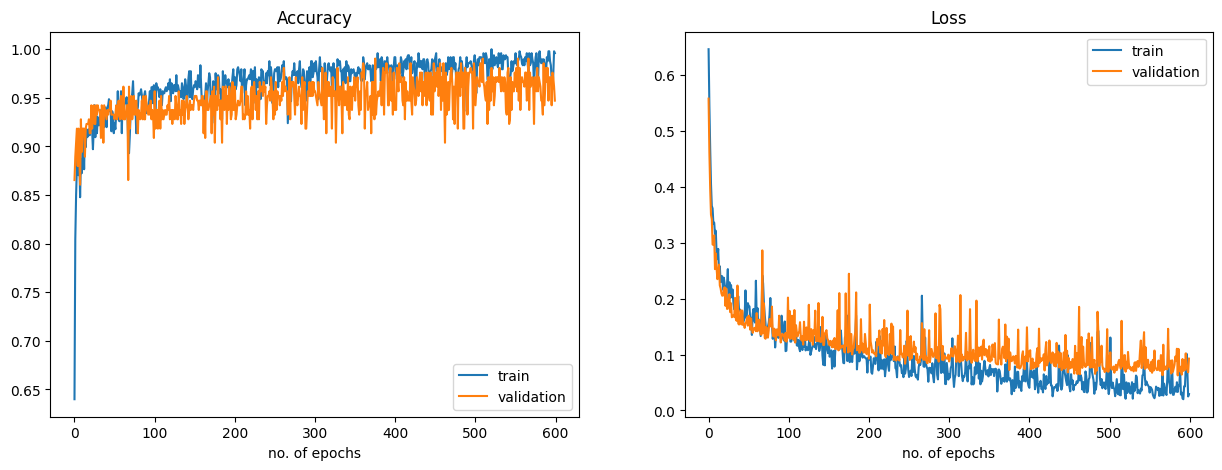


 The best results for few_transformations:


,train,val
loss,0.0382,0.0675
acc,0.9918,0.9856


In [ ]:
model_trained_few, metrics_few, history_few = train_model(dataloaders_few,
                                                          model,
                                                          criterion,
                                                          optimizer,
                                                          num_epochs=600)

plot_learning(history_few)

print(f'\n The best results for few_transformations:')
metrics_few

In [ ]:
torch.save(model_trained_few.state_dict(),'/content/drive/MyDrive/Models/Alien_vs_Predator/best_model_few.pt')

###RI_transformations

Epoch 1/500
train loss: 0.3451, train accuracy: 0.8683
val loss: 0.2657, val accuracy: 0.8894
Epoch 2/500
train loss: 0.2385, train accuracy: 0.9136
val loss: 0.3241, val accuracy: 0.8702
Epoch 3/500
train loss: 0.3781, train accuracy: 0.8086
val loss: 0.1675, val accuracy: 0.9423
Epoch 4/500
train loss: 0.1928, train accuracy: 0.9280
val loss: 0.1661, val accuracy: 0.9423
Epoch 5/500
train loss: 0.1819, train accuracy: 0.9239
val loss: 0.1456, val accuracy: 0.9519
Epoch 6/500
train loss: 0.2086, train accuracy: 0.9074
val loss: 0.1449, val accuracy: 0.9375
Epoch 7/500
train loss: 0.1345, train accuracy: 0.9527
val loss: 0.1292, val accuracy: 0.9519
Epoch 8/500
train loss: 0.1559, train accuracy: 0.9383
val loss: 0.1283, val accuracy: 0.9615
Epoch 9/500
train loss: 0.1546, train accuracy: 0.9280
val loss: 0.1232, val accuracy: 0.9567
Epoch 10/500
train loss: 0.1087, train accuracy: 0.9733
val loss: 0.1331, val accuracy: 0.9615
Epoch 11/500
train loss: 0.0997, train accuracy: 0.9691
val

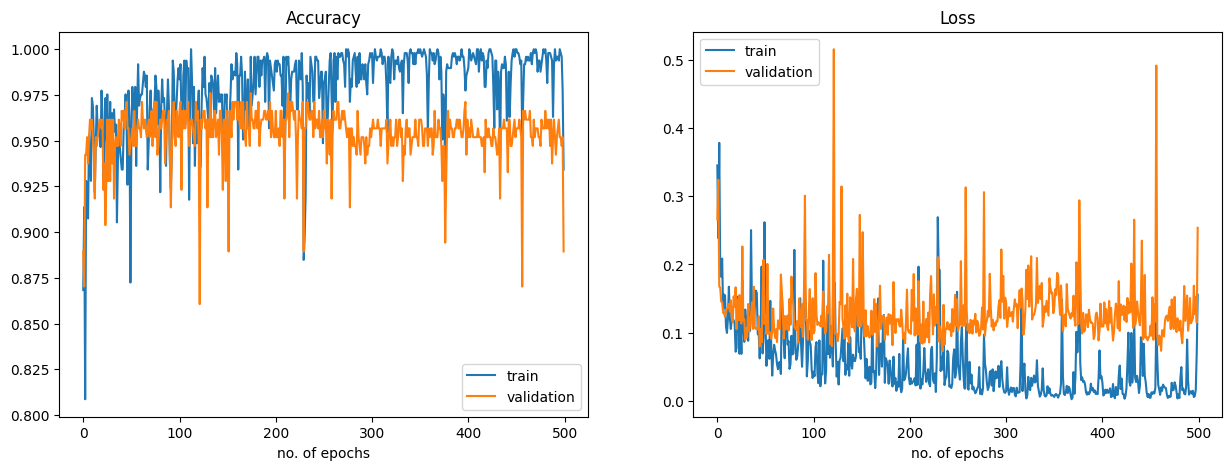


 The best results for ri_transformations:


,train,val
loss,0.0170,0.0986
acc,0.9979,0.9712


In [ ]:
dataloaders_ri = create_dataloaders(transforms.RandomInvert())

model_trained_ri, metrics_ri, history_ri = train_model(dataloaders_ri,
                                                          model,
                                                          criterion,
                                                          optimizer,
                                                          num_epochs=500)

plot_learning(history_ri)

print(f'\n The best results for ri_transformations:')
metrics_ri

In [ ]:
torch.save(model_trained_ri.state_dict(),'/content/drive/MyDrive/Models/Alien_vs_Predator/best_model_ri.pt')

###RA_transformation

Epoch 1/400
train loss: 0.5308, train accuracy: 0.7037
val loss: 0.3336, val accuracy: 0.9038
Epoch 2/400
train loss: 0.3168, train accuracy: 0.8642
val loss: 0.2258, val accuracy: 0.9327
Epoch 3/400
train loss: 0.2087, train accuracy: 0.9239
val loss: 0.1864, val accuracy: 0.9279
Epoch 4/400
train loss: 0.1725, train accuracy: 0.9403
val loss: 0.3305, val accuracy: 0.8462
Epoch 5/400
train loss: 0.1741, train accuracy: 0.9300
val loss: 0.2521, val accuracy: 0.8702
Epoch 6/400
train loss: 0.1407, train accuracy: 0.9465
val loss: 0.1490, val accuracy: 0.9375
Epoch 7/400
train loss: 0.1096, train accuracy: 0.9650
val loss: 0.2045, val accuracy: 0.9183
Epoch 8/400
train loss: 0.1221, train accuracy: 0.9403
val loss: 0.1645, val accuracy: 0.9279
Epoch 9/400
train loss: 0.0923, train accuracy: 0.9609
val loss: 0.1382, val accuracy: 0.9423
Epoch 10/400
train loss: 0.2072, train accuracy: 0.9115
val loss: 0.3287, val accuracy: 0.8558
Epoch 11/400
train loss: 0.1000, train accuracy: 0.9691
val

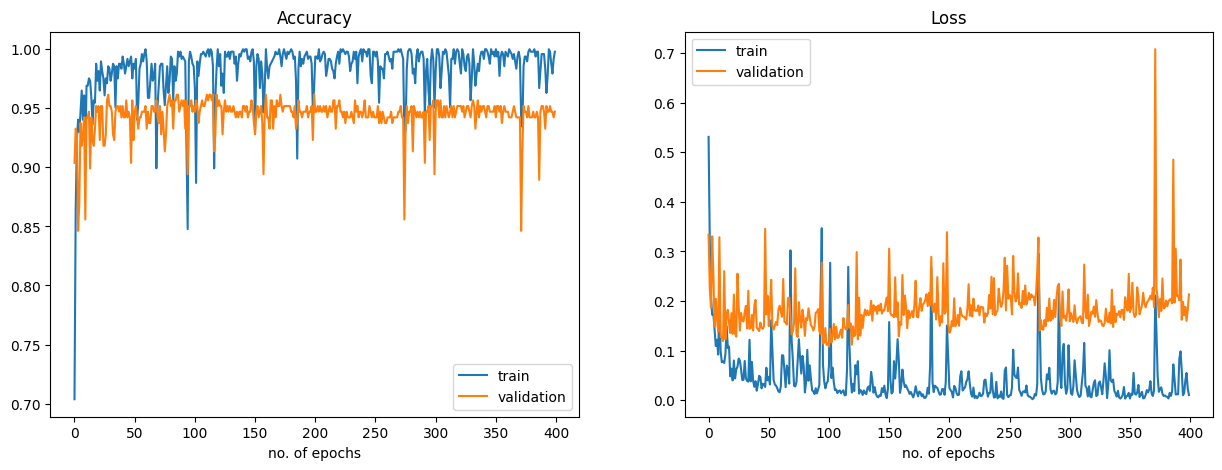


 The best results for ra_transformations:


,train,val
loss,0.0151,0.1577
acc,1.0000,0.9615


In [ ]:
dataloaders_ra = create_dataloaders(transforms.RandomAutocontrast())

model_trained_ra, metrics_ra, history_ra = train_model(dataloaders_ra,
                                                          model,
                                                          criterion,
                                                          optimizer,
                                                          num_epochs=400)

plot_learning(history_ra)

print(f'\n The best results for ra_transformations:')
metrics_ra

In [ ]:
torch.save(model_trained_ra.state_dict(),'/content/drive/MyDrive/Models/Alien_vs_Predator/best_model_ra.pt')

###RE_transformations

Epoch 1/400
train loss: 0.5394, train accuracy: 0.7016
val loss: 0.3127, val accuracy: 0.8846
Epoch 2/400
train loss: 0.3441, train accuracy: 0.8498
val loss: 0.2075, val accuracy: 0.9327
Epoch 3/400
train loss: 0.3061, train accuracy: 0.8827
val loss: 0.2161, val accuracy: 0.9087
Epoch 4/400
train loss: 0.1967, train accuracy: 0.9362
val loss: 0.1872, val accuracy: 0.9135
Epoch 5/400
train loss: 0.2040, train accuracy: 0.9300
val loss: 0.1710, val accuracy: 0.9327
Epoch 6/400
train loss: 0.1505, train accuracy: 0.9444
val loss: 0.1458, val accuracy: 0.9423
Epoch 7/400
train loss: 0.1978, train accuracy: 0.9239
val loss: 0.1395, val accuracy: 0.9327
Epoch 8/400
train loss: 0.2179, train accuracy: 0.9198
val loss: 0.1490, val accuracy: 0.9327
Epoch 9/400
train loss: 0.1350, train accuracy: 0.9609
val loss: 0.1324, val accuracy: 0.9471
Epoch 10/400
train loss: 0.2412, train accuracy: 0.9095
val loss: 0.1232, val accuracy: 0.9567
Epoch 11/400
train loss: 0.3269, train accuracy: 0.8519
val

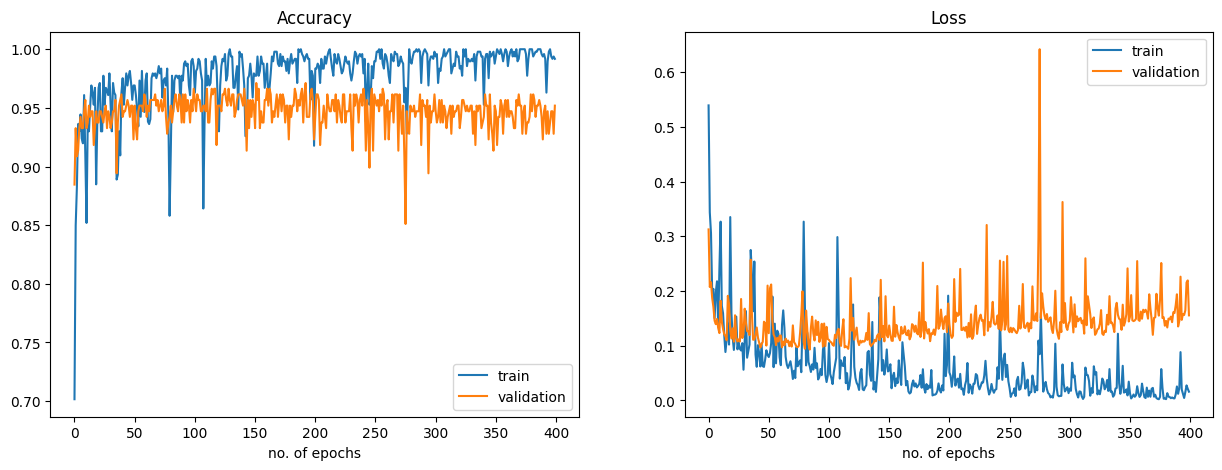


 The best results for re_transformations:


,train,val
loss,0.0121,0.1348
acc,0.9959,0.9663


In [ ]:
dataloaders_re = create_dataloaders(transforms.RandomEqualize())

model_trained_re, metrics_re, history_re = train_model(dataloaders_re,
                                                          model,
                                                          criterion,
                                                          optimizer,
                                                          num_epochs=400)

plot_learning(history_re)

print(f'\n The best results for re_transformations:')
metrics_re

In [ ]:
torch.save(model_trained_re.state_dict(),'/content/drive/MyDrive/Models/Alien_vs_Predator/best_model_re.pt')

###TAW_transformations

Epoch 1/600
train loss: 0.7359, train accuracy: 0.5967
val loss: 0.6129, val accuracy: 0.6923
Epoch 2/600
train loss: 0.5575, train accuracy: 0.8272
val loss: 0.4730, val accuracy: 0.8606
Epoch 3/600
train loss: 0.4172, train accuracy: 0.8765
val loss: 0.3305, val accuracy: 0.9038
Epoch 4/600
train loss: 0.3143, train accuracy: 0.9033
val loss: 0.3046, val accuracy: 0.8702
Epoch 5/600
train loss: 0.2977, train accuracy: 0.8683
val loss: 0.2883, val accuracy: 0.8798
Epoch 6/600
train loss: 0.2297, train accuracy: 0.9136
val loss: 0.1917, val accuracy: 0.9231
Epoch 7/600
train loss: 0.2294, train accuracy: 0.9156
val loss: 0.1850, val accuracy: 0.9279
Epoch 8/600
train loss: 0.2238, train accuracy: 0.9012
val loss: 0.2998, val accuracy: 0.8510
Epoch 9/600
train loss: 0.2514, train accuracy: 0.8951
val loss: 0.2302, val accuracy: 0.9087
Epoch 10/600
train loss: 0.2518, train accuracy: 0.9053
val loss: 0.1591, val accuracy: 0.9375
Epoch 11/600
train loss: 0.1568, train accuracy: 0.9527
val

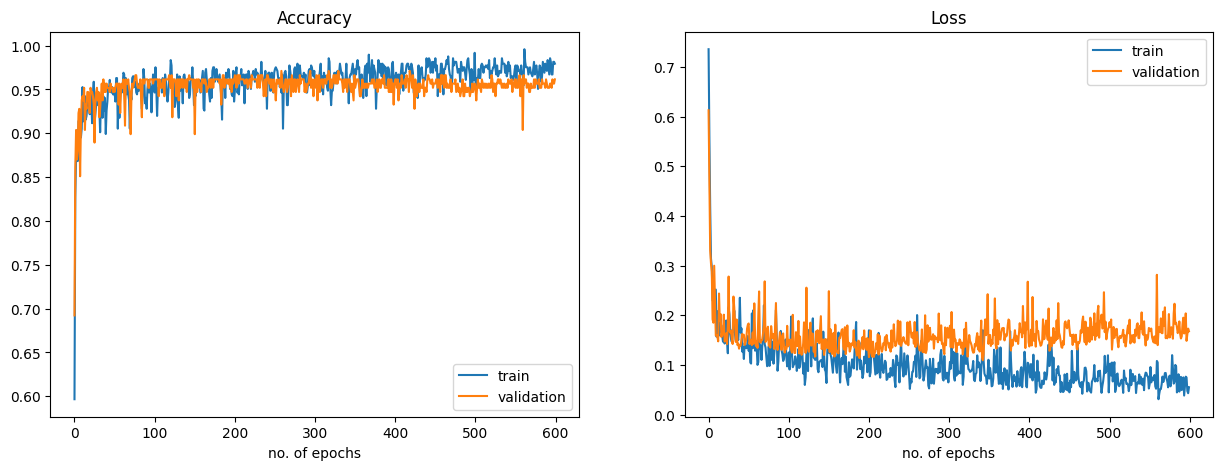


 The best results for taw_transformations:


,train,val
loss,0.0598,0.1215
acc,0.9856,0.9712


In [ ]:
dataloaders_taw = create_dataloaders(transforms.TrivialAugmentWide())

model_trained_taw, metrics_taw, history_taw = train_model(dataloaders_taw,
                                                          model,
                                                          criterion,
                                                          optimizer,
                                                          num_epochs=600)

plot_learning(history_taw)

print(f'\n The best results for taw_transformations:')
metrics_taw

In [ ]:
torch.save(model_trained_taw.state_dict(),'/content/drive/MyDrive/Models/Alien_vs_Predator/best_model_taw.pt')

###AutoA_transformations

Epoch 1/600
train loss: 0.8405, train accuracy: 0.5206
val loss: 0.6274, val accuracy: 0.7452
Epoch 2/600
train loss: 0.6203, train accuracy: 0.7346
val loss: 0.5391, val accuracy: 0.8462
Epoch 3/600
train loss: 0.5089, train accuracy: 0.8292
val loss: 0.4301, val accuracy: 0.9087
Epoch 4/600
train loss: 0.4464, train accuracy: 0.8292
val loss: 0.3364, val accuracy: 0.9038
Epoch 5/600
train loss: 0.3942, train accuracy: 0.8498
val loss: 0.2758, val accuracy: 0.9279
Epoch 6/600
train loss: 0.3533, train accuracy: 0.8642
val loss: 0.2732, val accuracy: 0.9038
Epoch 7/600
train loss: 0.2673, train accuracy: 0.9218
val loss: 0.2368, val accuracy: 0.9183
Epoch 8/600
train loss: 0.2869, train accuracy: 0.8827
val loss: 0.2082, val accuracy: 0.9279
Epoch 9/600
train loss: 0.2933, train accuracy: 0.8992
val loss: 0.1919, val accuracy: 0.9423
Epoch 10/600
train loss: 0.2278, train accuracy: 0.9156
val loss: 0.3194, val accuracy: 0.8558
Epoch 11/600
train loss: 0.3284, train accuracy: 0.8519
val

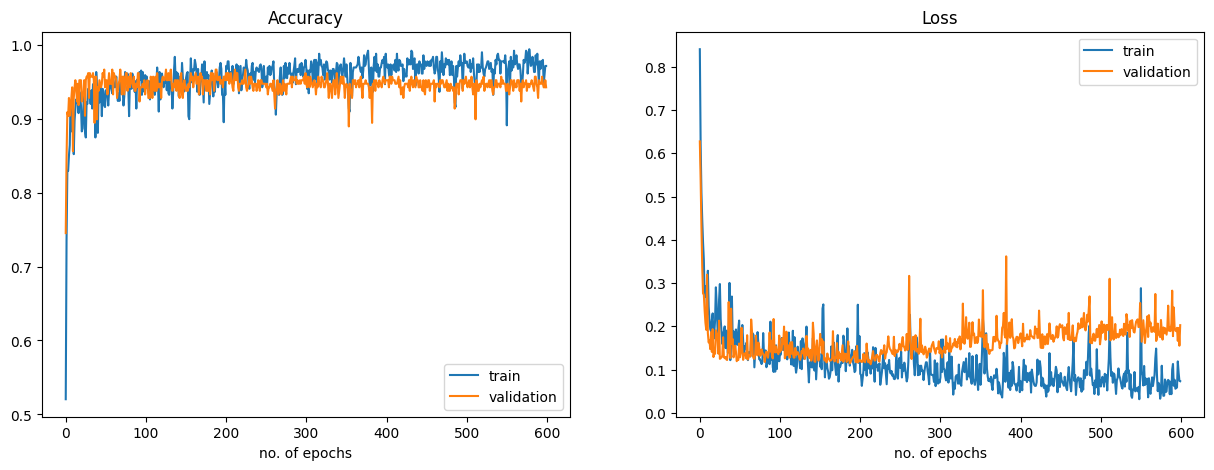


 The best results for aa_transformations:


,train,val
loss,0.1142,0.1186
acc,0.9630,0.9663


In [ ]:
dataloaders_aa = create_dataloaders(transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET))

model_trained_aa, metrics_aa, history_aa = train_model(dataloaders_aa,
                                                          model,
                                                          criterion,
                                                          optimizer,
                                                          num_epochs=600)

plot_learning(history_aa)

print(f'\n The best results for aa_transformations:')
metrics_aa

In [ ]:
torch.save(model_trained_aa.state_dict(),'/content/drive/MyDrive/Models/Alien_vs_Predator/best_model_aa.pt')

##Evaluate

In [ ]:
outcomes = pd.concat([metrics_few, metrics_ri, metrics_ra, metrics_re, metrics_taw, metrics_aa],
                     keys=['few_transformation', 'RI_transformation', 'RA_transformation', 'RE_transformation', 'TAW_transformation', 'AutoA_transformation'])
outcomes

train     val
few_transformation   loss  0.0382  0.0675
                     acc   0.9918  0.9856
RI_transformation    loss  0.0170  0.0986
                     acc   0.9979  0.9712
RA_transformation    loss  0.0151  0.1577
                     acc   1.0000  0.9615
RE_transformation    loss  0.0121  0.1348
                     acc   0.9959  0.9663
TAW_transformation   loss  0.0351  0.1554
                     acc   0.9877  0.9615
AutoA_transformation loss  0.1142  0.1186
                     acc   0.9630  0.9663

##Loading model

##Prediction

In [ ]:
dataloaders = dataloaders_few
best_model = model
best_model.load_state_dict(torch.load('/content/drive/MyDrive/Models/Alien_vs_Predator/best_model_few.pt'))
loss, accuracy = test_model(dataloaders['test'], best_model, criterion)
print(f'Accuracy for test dataset: {accuracy:.4f}')
print(f'Loss for test dataset: {loss:.4f}')

Accuracy for test dataset: 0.9400
Loss for test dataset: 0.1772


###Sample preditions

In [ ]:
data_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(), normalize])

In [ ]:
img_label_list = [rand_image('test') for i in range(4)]
img_list = [img_label_list[i][0] for i in range(4)]
label_list = [img_label_list[i][1] for i in range(4)]

In [ ]:
test_batch = torch.stack([data_transforms(img).to(device) for img in img_list])

pred_logits_tensor = best_model(test_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()*100

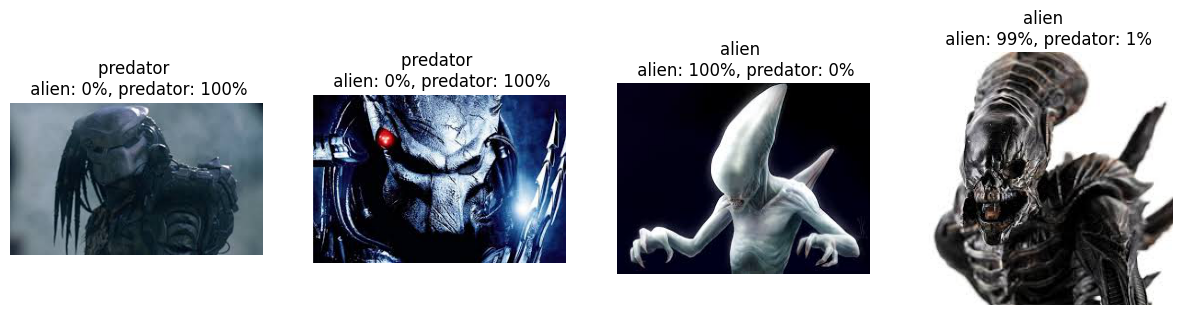

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))

for i, img in enumerate(img_list):
  ax = axs[i]
  ax.axis('off')
  ax.set_title(f'{label_list[i]} \n alien: {pred_probs[i,0]:.0f}%, predator: {pred_probs[i,1]:.0f}%')
  ax.imshow(img)